<a href="https://colab.research.google.com/github/Maxime-Bakunzi/medical-education-chatbot/blob/main/medical_medical_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Education Chatbot Training Notebook

 In this notebook, we:
 1. Install necessary packages and import libraries.
 2. Mount Google Drive and download required NLTK data.
 3. Load and sample the medical dialogue dataset, and display its head.
 4. Create a custom dataset class for tokenization.
 5. Initialize a lightweight transformer model (`distilgpt2`) and train it with memory-friendly settings.
 6. Evaluate the model using BLEU and F1 scores.
 7. Create a simple Gradio interface for interacting with the chatbot.


## Install required packages

In [1]:
!pip install datasets gradio transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 934.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver do

## Importing necessary packages

In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    T5ForConditionalGeneration
)
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import nltk
from nltk.translate.bleu_score import sentence_bleu
import gradio as gr

In [3]:
# Download necessary NLTK packages
nltk.download('punkt')

# Create necessary directories for storing dataset, models, and logs
BASE_PATH = '/content/drive/MyDrive/medical_education_chatbot'
MODELS_PATH = os.path.join(BASE_PATH, 'models')
LOGS_PATH = os.path.join(BASE_PATH, 'logs')
DATASET_PATH = os.path.join(BASE_PATH, 'dataset')

for path in [BASE_PATH, MODELS_PATH, LOGS_PATH, DATASET_PATH]:
    os.makedirs(path, exist_ok=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 1. Load and Prepare Dataset

In [4]:
# Load and preprocess the dataset
print("Loading dataset...")
ds = load_dataset("ruslanmv/ai-medical-chatbot")
df_full = pd.DataFrame(ds["train"])
print("Dataset head:")
print(df_full.head())

# Sample 10% of the dataset for faster training
df_sample = df_full.sample(frac=0.1, random_state=42)

# Rename the columns to 'instruction' and 'output' if necessary
df_sample = df_sample.rename(columns={"Patient": "instruction", "Doctor": "output"})

# Save the sampled dataset for future reference
dataset_file = os.path.join(DATASET_PATH, "medical_dialogues_sampled.csv")
df_sample.to_csv(dataset_file, index=False)

print(f"Sampled dataset shape: {df_sample.shape}")
print(f"Sample of the dataset:")
print(df_sample.head())

# Data exploration and visualization
print("\nBasic Dataset Statistics:")
print(f"Number of dialogues: {len(df_sample)}")
print(f"Average question length: {df_sample['instruction'].str.len().mean():.2f} characters")
print(f"Average response length: {df_sample['output'].str.len().mean():.2f} characters")

Loading dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/863 [00:00<?, ?B/s]

dialogues.parquet:   0%|          | 0.00/142M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/256916 [00:00<?, ? examples/s]

Dataset head:
                                         Description  \
0      Q. What does abutment of the nerve root mean?   
1  Q. What should I do to reduce my weight gained...   
2  Q. I have started to get lots of acne on my fa...   
3  Q. Why do I have uncomfortable feeling between...   
4  Q. My symptoms after intercourse threatns me e...   

                                             Patient  \
0  Hi doctor,I am just wondering what is abutting...   
1  Hi doctor, I am a 22-year-old female who was d...   
2  Hi doctor! I used to have clear skin but since...   
3  Hello doctor,I am having an uncomfortable feel...   
4  Hello doctor,Before two years had sex with a c...   

                                              Doctor  
0  Hi. I have gone through your query with dilige...  
1  Hi. You have really done well with the hypothy...  
2  Hi there Acne has multifactorial etiology. Onl...  
3  Hello. The popping and discomfort what you fel...  
4  Hello. The HIV test uses a finger 

In [17]:
df_sample.head()

,Description,instruction,output
182751,Suggest remedy for itchy red bump on my toe,hi I had a red bump on my toe that itched at f...,HelloIt may be due to allergy or infection.Swe...
143970,What is the treatment for loose motion in a ch...,"Hello sir,baby of age 7 months...suffering wit...","Hello, Loose stools continue due to viral illn..."
200010,Can headache and face flushes be connected to ...,i have a teratoma in my spleen(17 cm) i found ...,Hello and welcome to ‘Ask A Doctor’ service. I...
131088,"Mild degenerative changes in clerical spine, n...",I have mild degenerative changes in clerical s...,Thanks for writing to us.You have cervical spi...
214296,What causes hard lump under left nipple?,I have a lump under my left nipple that is the...,Hi dear thanks for the query on HCMLump in you...


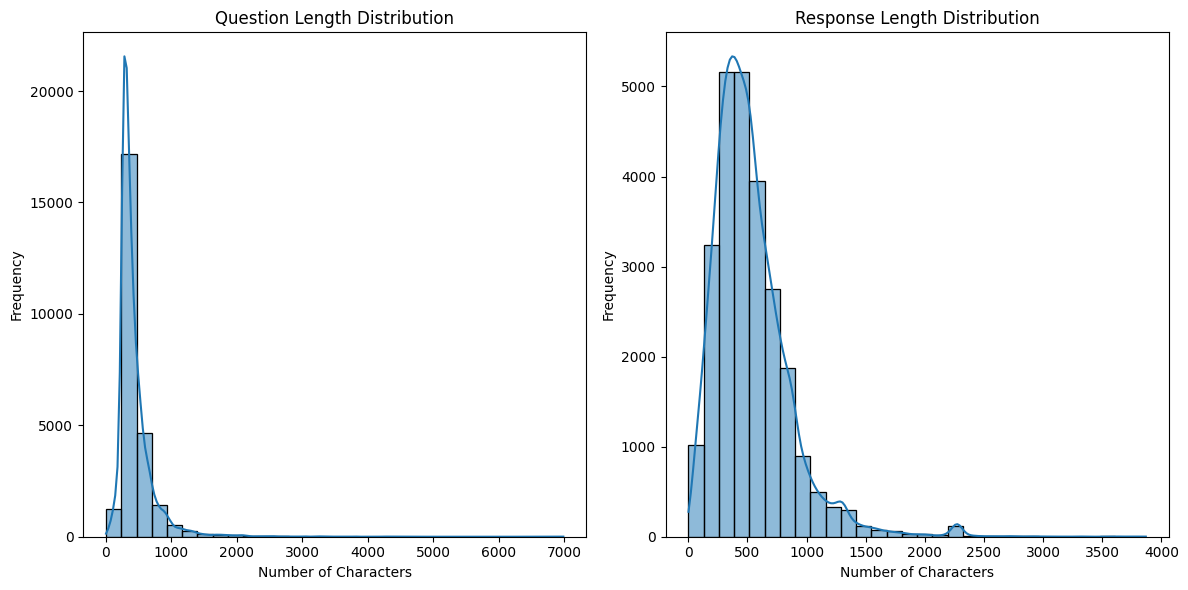

In [5]:
# Visualize the length distribution of questions and answers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_sample['instruction'].str.len(), bins=30, kde=True)
plt.title('Question Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df_sample['output'].str.len(), bins=30, kde=True)
plt.title('Response Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(os.path.join(LOGS_PATH, 'length_distribution.png'))
plt.show()


## 2. Dataset Class and Tokenization

In [6]:
# Prepare the dataset for training
train_df, val_df = train_test_split(df_sample, test_size=0.1, random_state=42)
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# Select a smaller and more efficient model: T5-small
MODEL_NAME = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Function to preprocess the data
def preprocess_function(examples):
    # Prefix for T5 model
    inputs = ["answer medical question: " + question for question in examples["instruction"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    # Tokenize targets
     # Convert the Pandas Series to a list of strings
    labels = tokenizer(examples["output"].tolist(), max_length=512, truncation=True, padding="max_length")

    # Replace padding token id with -100 for loss calculation
    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply preprocessing to training and validation sets
train_data = preprocess_function(train_df)
val_data = preprocess_function(val_df)

# Create PyTorch datasets
class MedicalDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.input_ids = data["input_ids"]
        self.attention_mask = data["attention_mask"]
        self.labels = data["labels"]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx]),
            "attention_mask": torch.tensor(self.attention_mask[idx]),
            "labels": torch.tensor(self.labels[idx])
        }

train_dataset = MedicalDataset(train_data)
val_dataset = MedicalDataset(val_data)

Training set size: 23122
Validation set size: 2570


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

## 3. Model Setup and Training


In [7]:
# Initialize the model
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)

# Define training arguments - optimized for faster training
training_args = Seq2SeqTrainingArguments(
    output_dir=os.path.join(MODELS_PATH, "t5-medical-education"),
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,  # Reduced for faster training
    predict_with_generate=True,
    logging_dir=LOGS_PATH,
    logging_steps=100,
    push_to_hub=False,
)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [8]:
# Define metrics for evaluation
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # Replace -100 with pad token id
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id

    # Decode predictions and labels
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    # Calculate BLEU score
    bleu_scores = []
    for pred, ref in zip(pred_str, labels_str):
        pred_tokens = nltk.word_tokenize(pred.lower())
        ref_tokens = nltk.word_tokenize(ref.lower())
        bleu = sentence_bleu([ref_tokens], pred_tokens)
        bleu_scores.append(bleu)

    avg_bleu = np.mean(bleu_scores)

    return {"bleu": avg_bleu}

# Initialize trainer
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=MODEL_NAME)
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

<ipython-input-8-00cf588acf50>:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [9]:
!pip install nltk
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [10]:
# Train the model
print("Starting model training...")
trainer.train()

# Save the trained model
model_save_path = os.path.join(MODELS_PATH, "t5-medical-education-final")
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Starting model training...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: m-bakunzi (m-bakunzi-african-leadership-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Bleu
1,3.688100,3.425483,0.001809
2,3.529900,3.306601,0.001881
3,3.563200,3.273671,0.003196


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Model saved to /content/drive/MyDrive/medical_education_chatbot/models/t5-medical-education-final


## 4. Evaluation Metrics

In [11]:
# Evaluate the model on the validation set
print("Evaluating model on validation set...")
results = trainer.evaluate()
print(f"Evaluation results: {results}")

# Save evaluation results
with open(os.path.join(LOGS_PATH, 'evaluation_results.txt'), 'w') as f:
    for key, value in results.items():
        f.write(f"{key}: {value}\n")

Evaluating model on validation set...


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Evaluation results: {'eval_loss': 3.2736709117889404, 'eval_bleu': 0.0031956641071522567, 'eval_runtime': 160.5228, 'eval_samples_per_second': 16.01, 'eval_steps_per_second': 2.006, 'epoch': 3.0}


In [15]:
# Create a function to generate responses from the trained model
def generate_response(question, model, tokenizer, max_length=600):
    input_text = "answer medical question: " + question
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(model.device) # Move input_ids to the model's device

    # Generate response
    outputs = model.generate(
        input_ids,
        max_length=max_length,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2
    )

    # Decode the generated response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Test the model with a few sample questions
test_questions = [
    "What are the symptoms of Type 2 Diabetes?",
    "How does insulin work in the body?",
    "What are the best practices for maintaining a healthy heart?",
    "What is the pathophysiology of Alzheimer's disease?"
]

print("\nTesting model with sample questions:")
for question in test_questions:
    response = generate_response(question, model, tokenizer)
    print(f"Q: {question}")
    print(f"A: {response}")
    print("-" * 50)


Testing model with sample questions:
Q: What are the symptoms of Type 2 Diabetes?
A: Hello and Welcome to ‘Ask A Doctor’ service. I have reviewed your query and here is my advice. Type 2 diabetes is a type 2 diabetic disease. It is an autoimmune disease that can cause the symptoms of diabetes. Diabetes is usually referred to as diabetes, which can be due to the underlying causes of Diabetes. The symptoms are not related to diabetes and it can also be linked to fibromyalgia. If you are having diabetes then you should consult an orthopaedic surgeon and get evaluated. Take care.
--------------------------------------------------
Q: How does insulin work in the body?
A: Hello and Welcome to ‘Ask A Doctor’ service. I have reviewed your query and here is my advice. Insulin works in the body and can be used in a variety of ways. If you have any questions, please do not hesitate in writing to us.
--------------------------------------------------
Q: What are the best practices for maintaining

## 5. Gradio Interface

In [16]:
# Create a Gradio interface for the chatbot
def chatbot_interface(question):
    return generate_response(question, model, tokenizer)

demo = gr.Interface(
    fn=chatbot_interface,
    inputs=gr.Textbox(lines=2, placeholder="Ask a medical education question..."),
    outputs="text",
    title="Medical Education Chatbot",
    description="Ask questions about medical concepts, diseases, treatments, and more."
)

# Launch the Gradio interface
print("Launching Gradio interface...")
demo.launch(share=True)  # Set share=True to create a public link

Launching Gradio interface...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://57541514a68bebd16b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
